In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import Concurrent_INREG
from importlib import reload
from math import exp

# INARCH type modèles

Creer des bouts de code pour le calcul de modèles type INARCH:


On s'interesse à des modèles de forme :

$$ x_{i,t} ~ Poisson(l_{i,t})) $$
$$ l_{i,t} = s(t) * f_{\theta}(\frac{x_{i,t-1}}{s(t)}) $$

$f_{\theta}$ choisi dans un ensemble de 
 
Et on cherche les valeurs de 

## I Génération de Données

In [2]:
M = 10
T = 140
al = 15
bet = 1
f_init = lambda x: al *x+bet
f_init_vect = np.vectorize(f_init)
np.random.seed(8)

In [3]:
from math import exp, log, sin,pi,cos

season_t =[100+  int(30 *cos(pi/30 * t)) for t in range(T+3)]

In [4]:
weight = np.random.exponential(0.5, size = M)
print(weight)

[1.03347752 1.72952973 1.01702205 0.37842243 0.13245717 0.00573213
 0.28147087 0.25737613 0.36977849 0.32541927]


In [5]:
mask = np.zeros((M,T))
for i in range(1,M):
    a = int(np.random.uniform(0,T-10))
    b = int(np.random.uniform(1,T-a))
    mask[i,a:a+b] = 1
mask[0,:]=1

In [6]:

x_list= list()
X_cur =  weight * mask[:,0] * season_t[0] /sum(weight * mask[:,0])
for i in range(T):
    x_list.append(X_cur.copy())
    Xsum =  f_init_vect( X_cur/(season_t[i]* weight)).dot( mask[:,i] * weight) 
    X_cur = mask[:,i] *  np.random.poisson(season_t[i+1] * f_init_vect(X_cur/(season_t[i]* weight)) * weight/Xsum, M)

data_mat = np.concatenate(x_list).reshape(T,M)
data_mat = data_mat[20:-20,:]
season_t = season_t[20:-21]
T = T-40

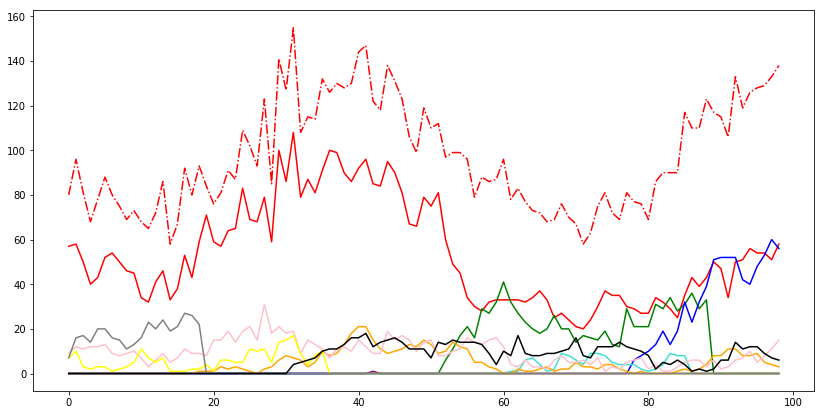

In [7]:
plt.figure(figsize=(14, 7))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue', 'turquoise','orange', 'purple', 'pink','yellow', 'grey','black'])
plt.plot(data_mat[1:,:])
plt.plot(data_mat[1:,:].sum(axis=1), '-.')
plt.show()

## II Concurrent models


In [8]:
reload(Concurrent_INREG)

horizon = 3
history = 1

In [9]:
model = Concurrent_INREG.Concurrent_INAR(season=data_mat[1:,:].sum(axis=1), horizon= horizon, history =history, cst=False)
model.estim_weight(data_mat[1:,:])
model.fit(data_mat, options ={'disp' : True})
pred = model.pred(data_mat[:-horizon,:])

In [10]:
model.weight/sum(model.weight)

array([0.09614834, 0.1633251 , 0.13267108, 0.06329921, 0.0443949 ,
       0.09614834, 0.05867863, 0.07587695, 0.19842145, 0.071036  ])

In [11]:
weight/sum(weight)

array([0.18686245, 0.31271524, 0.18388715, 0.06842233, 0.0239495 ,
       0.00103642, 0.05089258, 0.04653602, 0.06685943, 0.05883886])

In [12]:
model.parameters#/model.parameters[0]

array([1.])

In [13]:
al,bet

(15, 1)

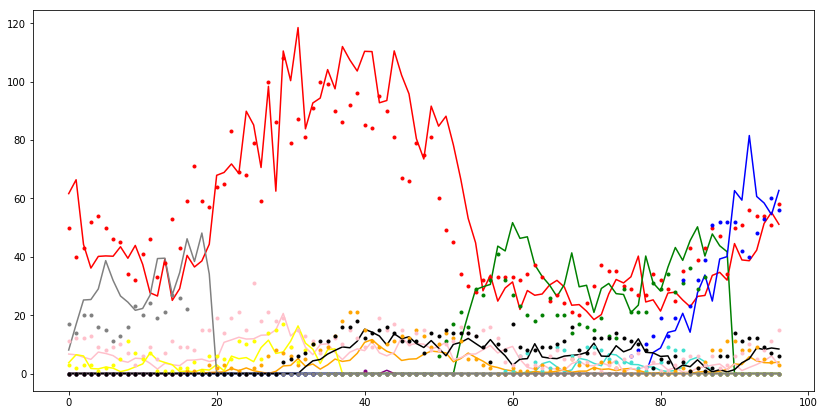

In [14]:
plt.figure(figsize=(14, 7))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue', 'turquoise','orange', 'purple', 'pink','yellow', 'grey','black'])
plt.plot(pred[:,:])
plt.plot(data_mat[horizon:,:],'.')
#plt.plot(pred.sum(axis=1), '-.')
plt.show()

In [15]:
model_bis =  Concurrent_INREG.Concurrent_log_INAR(season=data_mat[1:,:].sum(axis=1), horizon= horizon, history =history)
model_bis.estim_weight(data_mat[horizon:,:])
model_bis.fit(data_mat, options ={'disp' : True})
pred_log = model_bis.pred(data_mat[:-horizon,:])

In [16]:
model.parameters

array([1.])

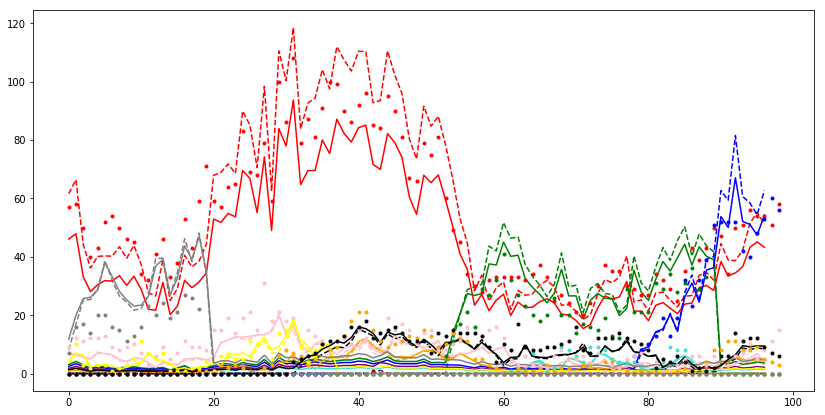

In [17]:
plt.figure(figsize=(14, 7))
plt.gca().set_prop_cycle('color', ['red', 'green', 'blue', 'turquoise','orange', 'purple', 'pink','yellow', 'grey','black'])
plt.plot(pred[:,:],'--')
plt.plot(pred_log)
plt.plot(data_mat[1:,:],'.')
#plt.plot(pred.sum(axis=1), '-.')
plt.show()

In [18]:
model = Concurrent_INREG.Concurrent_INGARCH(season=data_mat[1:,:].sum(axis=1), horizon= horizon, history =history)
model.estim_weight(data_mat[1:,:])
model.fit(data_mat, options ={'disp' : True})
pred_G = model.pred(data_mat[:-horizon,:])

In [19]:
model.parameters

array([3.49549781e+01, 1.00000000e-03])